(572,)
-------------------------------------------------------
Testing on: ./MERITZ_DATA.csv
Test size: 0.200000
Number of days predicted: 4
Window size: 30
Trained on Samples 433
Testing Result:
              precision    recall  f1-score   support

         0.0       0.46      0.51      0.48        55
         1.0       0.44      0.39      0.41        54

    accuracy                           0.45       109
   macro avg       0.45      0.45      0.45       109
weighted avg       0.45      0.45      0.45       109

Training Result:
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       205
         1.0       0.90      0.91      0.90       228

    accuracy                           0.90       433
   macro avg       0.90      0.90      0.90       433
weighted avg       0.90      0.90      0.90       433

-------------------------------------------------------
(573,)
-------------------------------------------------------
Testing on: ./

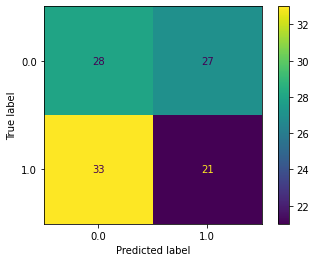

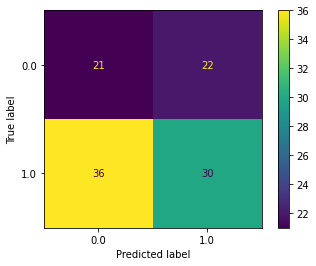

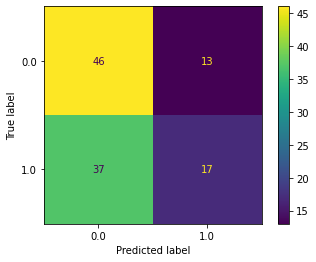

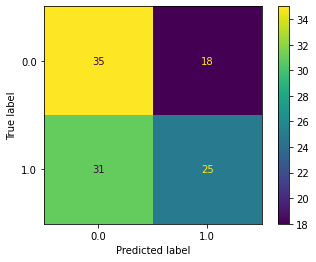

In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') 
#SVC(kernel = 'rbf', gamma = 1e-3, C = 100), day_num = 7, WINDOW = 50
def csv_extract(day_num, filename = "/MERITZ_DATA.csv"):
    '''
    Input: Number of samples, Number of Stocks, filename
    Output: numpy array of (number of samples, number of stocks)
    '''
    df = pd.read_csv(filename)
    sample_size = df['Open'].shape[0] - day_num
    X = np.empty((sample_size - day_num, 0))
    y = np.empty((sample_size - day_num))
    print(y.shape)

    #Feature Processing. Trying to keep in range [-1, 1]
    
    features = ['Open', 'High', 'Low', 'Close', 'Price_5', 'Price_10', 'Price_20',
                'Price_60', 'Price_120', 'Volume', 'Volume_5', 'Volume_10',
                'Volume_20', 'Volume_60', 'Volume_120', 'Volume Ratio', 'OBV',
                'MACD', 'MACD_Signal', 'Momentum', 'Momentum_Signal', 'William_R',
                'William_D', 'Psychology', 'Psychology_Signal', 'MFI',
                'MFI_Signal', 'RSI', 'RSI_Signal']
    
    # Features -> Close, Volume, Close - Price_120, Close - Price_60, Momentum
    for feature in features:
        if feature in ['Close', 'Volume', 'Momentum']:
            X_col = df[feature]
        if feature in ['Close', 'Open', 'Price_5', 'Volume', 'William_R', 'OBV']:
            X_col = df[feature]
        elif feature in ['Price_120', 'Price_60', 'Close']:
            X_col = df['Price_5'] - df[feature]
        elif feature in ['Momentum', 'Psychology', 'RSI', 'MFI']:
            X_col = df[feature] - df[feature + '_Signal']
        else:
            continue
        X = np.column_stack((X, X_col[0 : sample_size - day_num]))
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if np.isnan(X[i, j]):
                X[i, j] = 0
                
    for n in range(sample_size - day_num):
        pct = 100 * (df['Close'][n + day_num] - df['Close'][n]) / df['Close'][n]
        if pct >= 0:
            y[n] = 1
        else:
            y[n] = 0
        #y[n] = 1 if df['Close'][n + day_num] >= df['Close'][n] else 0
    return X, y

def feature_extract(X, window = 10):
    feature_num = X.shape[1]
    for i in range(window, X.shape[0]):
        x = X[i - window: i]
        x = x.T.reshape(x.shape[0] * x.shape[1])
        for j in np.arange(0, window*feature_num, window):
            x[j : j + window] = preprocessing.scale(x[j : j + window])
            #x[j : j + window] = (x[j : j + window])/np.max(x[j : j + window])
            pass
        if i == window:
            X_ = x
            continue
        X_ = np.vstack((X_, x))
    return X_    

for filename in ["./MERITZ_DATA.csv", "./JINRO_DATA.csv", "./CAFE24_DATA.csv", 
                "./KG_DATA.csv"]:
    for test_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if test_size != 0.2:
            continue
        WINDOW = 30
        day_num = 4
        X, y = csv_extract(day_num, filename = filename)
        X_, y_ = feature_extract(X, window = WINDOW), y[WINDOW:]
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, shuffle = False, test_size = test_size)
        '''clf = SVC(kernel = 'rbf', gamma = 1e-3, C = 1000)
        clf.fit(X_train, y_train)'''
        
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1],
             'C': [1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4]}]
        score = 'precision'
        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring = score, verbose = 0
        )    
        clf.fit(X_train, y_train)
        verbose = False
        if verbose:
            print("Best parameters set found on development set:")
            print()
            print(clf.best_params_)
            print()
            print("Grid scores on development set:")
            print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                % (mean, std * 2, params))
        
        y_pred = clf.predict(X_test)
        print('-------------------------------------------------------')
        print('Testing on: ' + filename)
        print('Test size: %f' %(test_size))
        print('Number of days predicted: %d' %(day_num))
        print('Window size: %d' %(WINDOW))
        print('Trained on Samples %d' %(X_train.shape[0]))
        print('Testing Result:')
        print(classification_report(y_test, y_pred))
        plot_confusion_matrix(clf, X_test, y_test)
        print('Training Result:')
        print(classification_report(y_train, clf.predict(X_train)))
        print('-------------------------------------------------------')
print('CLASSIFICATIONS COMPLETE')